<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma empresa focada em logística, fundada em 2013. Atualmente, está presente em mais de 4.000 municípios e possui dez centros de distribuição.

Neste projeto, a partir dos dados de Brasília e suas respectivas regiões, pretende-se responder os seguintes questionamentos:

1. Há uma proporcionalidade em relação às entregas por HUB?
2. Os HUBS estão bem localizados? Ou seja, entregam para regiões mais distantes ou não?

## 2\. Pacotes e bibliotecas

In [53]:
#importação das biliotecas que serão utilizadas

!pip3 install geopandas
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas


In [54]:
#download dos dados:

!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

## 3\. Exploração de dados

In [55]:
# faça o código de exploração de dados:

#lendo o arquivo json deliveries.
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)#criação de um dataframe a partir dos dados

# tratando a coluna origin

hub_origin_df = pd.json_normalize(deliveries_df["origin"]) #extraindo as informações da coluna origin e criando um dataframe com essas informações
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True) #mesclando esse novo dataframe com o original
deliveries_df = deliveries_df.drop("origin", axis=1)#remove a coluna original com o nome "origin"
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]] #como queremos saber as informações dos hubs, aqui extraímos apenas as infos relevantes
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)#renomeando algumas colunas.

# tratando a coluna deliveries

deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries") #com o objetivo de ter uma linha por entrega individual, usamos o 'exploded'
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)#extraindo as informações relevantes de cada entrega

deliveries_df = deliveries_df.drop("deliveries", axis=1)#descartando a coluna 'deliveries' original
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)#mesclando as informações normalizadas
deliveries_df.reset_index(inplace=True, drop=True)#reseta o índice do dataframe

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

In [56]:
# faça o código de manipulação de dados:

hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]#criação de um novo dataframe, com as informações de entrega
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)#remove as linhas duplicadas, ordena em ordem alfabética e reseta o índice
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [57]:
#aplicando a geocodificação nas três regiões de Brasília:

geolocator = Nominatim(user_agent="mainara_ebac_geocoder")#cria um user
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)#define o limite de chamadas

In [58]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)#extraindo as informações de cidade e bairro
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [59]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))#normalizando os dados em json, para que separe numero, nome da rua, bairro, etc
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [19]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]#selecionando apenas as colunas relevantes do endereço
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)#renomeando as colunas
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])#preencher os valores vazios "Nan" com os valores da coluna hub_town
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])#preencher os valores vazios com os valores da coluna hub_city
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)#removendo a coluna hub_town, pois esses valores foram colocados em colunas que estavam vazias
hub_geodata_df.head()

<ipython-input-19-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-19-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-19-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [20]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)#combinando o dataframe hub_df com o dataframe da geolocalização (hub_geodata_df)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]#selecionando apenas as informações relevantes
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [21]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")#combinando o dataframe de entregas (deliveries_df) com o dataframe dos dados dos hubs (hub_df)
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]#selecionando apenas as colunas relevantes
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [23]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")#lendo o arquivo de geodatada, com as informações das entregas
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [24]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)#combinando o dataframe das entregas com as informações de entrega
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [25]:
#Qualidade

deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [26]:
deliveries_df.isna().any()

,0
name,False
region,False
hub_lng,False
hub_lat,False
hub_city,False
hub_suburb,False
vehicle_capacity,False
delivery_size,False
delivery_lng,False
delivery_lat,False


In [31]:
deliveries_df.describe()

,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
count,636149.000000,636149.000000,636149.0,636149.000000,636149.000000,636149.000000
mean,-47.949902,-15.802359,180.0,5.512111,-47.946087,-15.809492
std,0.091875,0.053463,0.0,2.874557,0.112769,0.082462
min,-48.054989,-15.838145,180.0,1.000000,-48.280779,-16.050028
25%,-48.054989,-15.838145,180.0,3.000000,-48.035911,-15.842795
50%,-47.893662,-15.805118,180.0,6.000000,-47.928967,-15.814033
75%,-47.893662,-15.805118,180.0,8.000000,-47.883394,-15.769516
max,-47.802665,-15.657014,180.0,10.000000,-47.310611,-15.500355


É possível percever que a capacidade dos veículos, para todas as linhas, é 180, ou seja, não há uma variação na capacidade.

No que diz respeito ao tamanho da entrega (delivery_size), percebe-se que o mínimo é 1, o máximo é 10 e a média de tamanho é 5.5 por veículo. O desvio padrão é de 2.87.



## 5\. Visualização

In [32]:
# faça o código de visualização de dados:

#fazendo download do mapa do DF do site do IBGE

!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [40]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [41]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [42]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-62-e603026618dc>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


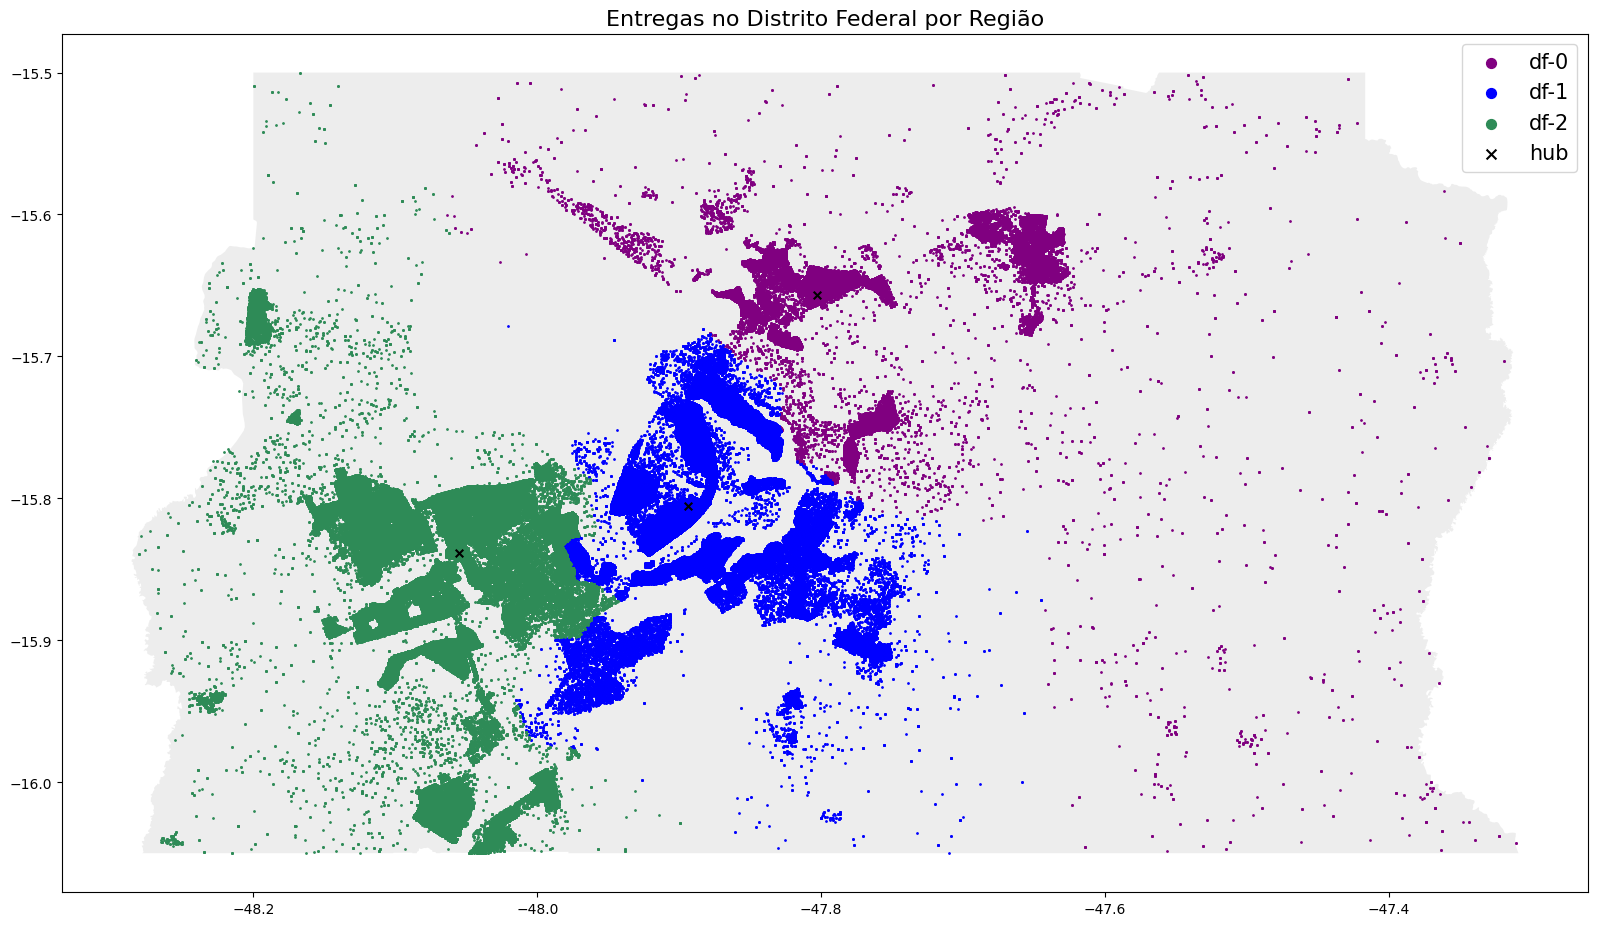

In [62]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="purple", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

Analisando o gráfico, nota-se que cada hub entrega próximo de onde está localizado.Entretanto, o hub da região df-0 faz entregas mais espaçadas e mais longes de onde está localizado, ao passo que o hub da região df-1 está muito bem localizado, pois as entregas realizadas por ele são mais centralizadas e mais próximas.


In [65]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-66-8e52272e9b83>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None, palette="deep")


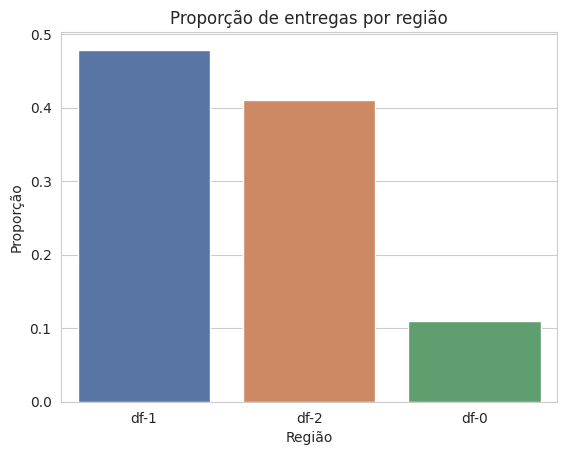

In [66]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", errorbar=None, palette="deep")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

O gráfico acima nos mostra que as regiões df-1 e df-2 são as que mais demandam por entregas.

A região df-0 não possui tantas entregas, mas com o mapa, notamos que a localização do hub faz com que hajam muitas entregas espaçadas.

Todos os hubs possuem a capacidade de 180 veículos, como foi visto nas primeiras análises dos dados. Como na região df-0 não possui tanta entrega, uma forma de suprir as necessidades das outras regiões, principalmente da região df-2, em que as entregas acabam sendo em locais mais distantes, poderia ser o remanejamento de veículos.

* Respondendo às perguntas iniciais do projeto:

1. **Há uma proporcionalidade em relação às entregas por HUB?**

Não. É perceptível que há mais necessidade de entregas nas regiões df-1 e df-2, embora todos os HUBS tenham a mesma capacidade de veículos.

2. **Os HUBS estão bem localizados? Ou seja, entregam para regiões mais distantes ou não?**

Os hubs estão bem localizados e o único que tem entregas localizadas é o hub da região df-1. Como a proporção maior de entrega é na região df-1 e, depois, na região df-2, alguns veículos do hub da região df-0 poderiam ser remanejados para as regiões onde há maior demanda.



